# Representing and comparing probabilities with kernels - practical

Notebook prepared by [Heiko Strathmann](http://herrstrathmann.de/) with additional code by [Dougal Sutherland](http://www.gatsby.ucl.ac.uk/~dougals/) and Kacper Chwialkowski.
Feel free to email any questions you have.

In this notebook, we will cover implementation details and applications for three types of kernel hypothesis tests:
    
* Two-sampling testing using the Maximum Mean Discrepancy (MMD)
* Independence testing using the Hilbert-Schmidt Independence Criterion (HSIC)
* Goodness-of-fit testing using the Kernel Stein Discrepancy (KSD)

On the fly, we will introduce basic concepts of statistical hypothesis testing.

The notebook contains a number of `# IMPLEMENT` comments, where you are supposed to insert missing code yourself.
We also prepared a solution notebook that contains the code we envisioned.

Cells are meant to be executed in order (i.e. cells might depend on previous ones).

## Dependencies
The notebook was written using Python 3.6, but we made an effort to keep it backwards compatible to older versions down to 2.7 (hopefully).

We encourage you to use a `conda` environment so you don't modify your system's Python setup (especially due to the problems that come with install TensorFlow and Shogun).

The packages you need are:
* A standard scipy setup covers most content: `numpy`, `scipy`, `matplotlib`, and of yource `jupyter`
* `tensorflow` for gradient-based optimization of test power on the MNIST-GAN example. Note we recommend to install this using `conda install -c conda-forge tensorflow `
* Optional: `scikit-learn` for a cross-validation splitting iterator (can implement yourself or use another lib)
* Optional: `seaborn`, `pandas` for convenient visualization in some examples
* Optional: `tqdm` for a fancy progress bar
* Optional: Shogun if you want to run a faster MMD test in the MNIST-GAN example: `conda install -c conda-forge shogun` (do this first as the package currently uses openblas and not MKL, so some of the other packages need to be re-installed).

This is an example how to set this environment up and run the notebook server
```
conda create --name ds3_kernels  python=3.6
source activate ds3_kernels
conda install -c conda-forge tensorflow 
conda install -c conda-forge shogun
conda install jupyter matplotlib scikit-learn seaborn pandas tqdm
jupyter notebook
```

See the Anaconda/TensorFlow/Shogun installation pages for more details.


## Additional files
All files can be found at https://github.com/karlnapf/ds3_kernel_testing.
They include

* This notebook and the solution notebook (we encourage you to not look at this before the practical has finished).
* **Provided Python modules**: We provide a few external modules that need to be in the `PYTHONPATH` of your notebook server (just put the files in the same folder as this notebook and start the server from this folder).
To see whether this worked, try ```import mmd```, and if it doesn't work, make sure that the file is present in one of the paths when you execute `import sys; print(sys.path)`.
* **Provided data**: Put those into the same folder as this notebook


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

try:
    from tqdm import tqdm_notebooks as tqdm
except ImportError:
    tqdm = lambda x: x

# Data (don't give it to students)

In [2]:
# mean shifted Gaussians
# N = 1000
# np.random.seed(0)
# X = np.random.randn(N)
# Y = np.random.randn(N) + 0.2
# np.savez("simple.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))

In [3]:
# gaussian vs laplace with same mean / variance
# from scipy.stats import laplace, norm

# def sample_gaussian_vs_laplace(n=220, mu=0.0, sigma2=1, b=np.sqrt(0.5)):
#     # sample from both distributions
#     X=norm.rvs(size=n)*np.sqrt(sigma2)+mu
#     Y=laplace.rvs(size=n, loc=mu, scale=b)

#     return X,Y

# np.random.seed(2)
# N=300
# X, Y = sample_gaussian_vs_laplace(n=N)
# np.savez("almost_simple.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))

In [4]:
# def sample_blobs(n, ratio, rows=5, cols=5, sep=10, rs=None):
#     # ratio is eigenvalue ratio
#     correlation = (ratio - 1) / (ratio + 1)

#     # generate within-blob variation
#     mu = np.zeros(2)
#     sigma = np.eye(2)
#     X = np.random.multivariate_normal(mu, sigma, size=n)

#     corr_sigma = np.array([[1, correlation], [correlation, 1]])
#     Y = np.random.multivariate_normal(mu, corr_sigma, size=n)

#     # assign to blobs
#     X[:, 0] += np.random.randint(rows, size=n) * sep
#     X[:, 1] += np.random.randint(cols, size=n) * sep
#     Y[:, 0] += np.random.randint(rows, size=n) * sep
#     Y[:, 1] += np.random.randint(cols, size=n) * sep

#     return X, Y

# np.random.seed(0)
# N=500
# ratio = 0.01
# rows_cols = 10
# X, Y = sample_blobs(n=N, rows=rows_cols, cols=rows_cols, ratio=ratio)
# np.savez("blobs.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))
# X, Y = sample_blobs(n=N, rows=rows_cols, cols=rows_cols, ratio=ratio)
# np.savez("blobs2.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))
# X, Y = sample_blobs(n=N, rows=1, cols=1, ratio=ratio)
# np.savez("blobs_zoomed.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))


In [5]:
# np.random.seed(0)
# N=400
# X = np.random.randn(N)
# Y = np.random.randn(N)
# np.savez("hsic1.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))

In [6]:
# def sample_hsic(n, angle, sigma=0.2, offset=1):
#     n4 = int(n/4)
#     N = np.random.randn(n4, 2)*sigma
#     S = np.random.randn(n4, 2)*sigma
#     E = np.random.randn(n4, 2)*sigma
#     W = np.random.randn(n4, 2)*sigma

#     N[:,1] += offset
#     S[:,1] -= offset
#     W[:,0] -= offset
#     E[:,0] += offset

#     R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
#     A = R.dot(np.vstack((N,S,W,E)).T).T

#     return A[:,0], A[:,1]

# N=200
# np.random.seed(0)
# X,Y = sample_hsic(n=N, angle=np.pi/12)
# np.savez("hsic2.npz", X=X.astype(np.float32), Y=Y.astype(np.float32))

# Two-sample testing

Let us begin with some simple data $X\sim P_X, Y\sim P_Y$.

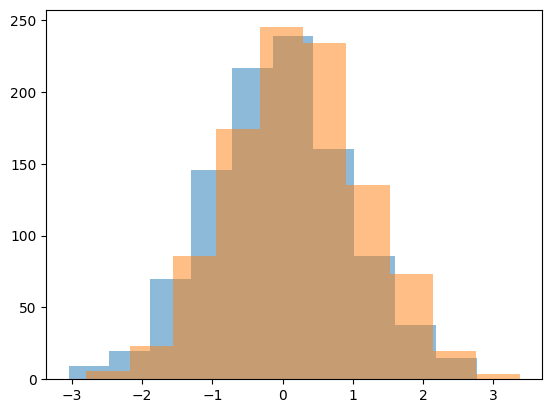

In [2]:
data = np.load("./data/simple.npz")
X = data["X"]
Y = data["Y"]
plt.hist(X, alpha=0.5)
plt.hist(Y, alpha=0.5);

Question: do X and Y come from the same distribution?
Or in other words: can we reject the null hypothesis that $P_X=P_Y$?

## The simplest of all test statistics

Let's start by comparing the means of the samples.
Clearly, if the distributions are the same, the mean would be zero.

In [3]:
def simple_statistic(X,Y, squared=False):
    assert X.ndim == Y.ndim == 1

    # IMPLEMENT: compute mean difference of X and Y
    result = np.mean(X) - np.mean(Y)

    if squared:
        result *= result
    return result

my_statistic = simple_statistic(X,Y)
print("Mean differencce:", my_statistic)

Mean differencce: -0.25887364


Significant?
What would it be if distributions were the same? What if they were different?

Let's assume that $P_X=P_Y$ and look at the distribution of the test statistic (null distribution).
For that, we can merge the samples and shuffle them, after which they have the same "joint" distribution.
We can then re-compute the statistic for multiple permutations to get a feeling for how the statistic is distributed.

In [4]:
def two_sample_permutation_test(test_statistic, X, Y, num_permutations, prog_bar=True):
    assert X.ndim == Y.ndim

    statistics = np.zeros(num_permutations)

    range_ = range(num_permutations)
    if prog_bar:
        range_ = tqdm(range_)
    for i in range_:
        # concatenate samples
        if X.ndim == 1:
            Z = np.hstack((X,Y))
        elif X.ndim == 2:
            Z = np.vstack((X,Y))

        # IMPLEMENT: permute samples and compute test statistic
        perm_inds = np.random.permutation(len(Z))
        Z = Z[perm_inds]
        X_ = Z[:len(X)]
        Y_ = Z[len(X):]
        my_test_statistic = test_statistic(X_, Y_)
        statistics[i] = my_test_statistic
    return statistics

num_permutations = 200
statistics = two_sample_permutation_test(simple_statistic, X, Y, num_permutations)

Now we have an idea about what to expect from the statistic in case where the distributions are equal.
How likely is our particular value of that statistic?
We can compare it against the say 95% quantiles of the null distribution.
If our statistic lies outside those, we can reject the null with a confidence of 0.05.

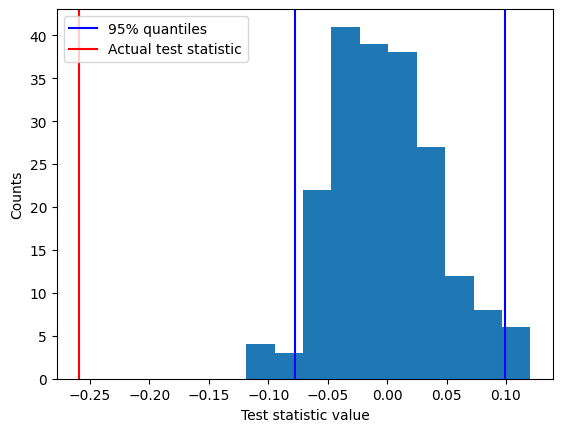

In [5]:
def plot_permutation_samples(null_samples, statistic=None):
    plt.hist(null_samples)
    plt.axvline(x=np.percentile(null_samples, 2.5), c='b')
    legend = ["95% quantiles"]
    if statistic is not None:
        plt.axvline(x=statistic, c='r')
        legend += ["Actual test statistic"]
    plt.legend(legend)
    plt.axvline(x=np.percentile(null_samples, 97.5), c='b')
    plt.xlabel("Test statistic value")
    plt.ylabel("Counts")

plot_permutation_samples(statistics, my_statistic)

Note that, depending on the test statistic, there might be multiple ways to compute the null distribution.
Not all of them work via sampling it directly, which also can be costly.
For example, if we just use the mean difference as a test statistic, and then plug in two Gaussian distributed random variables, we know that the distribution of the statistic is also Gaussian (see the above plot). 
We might be even able to analytically work out the parameters of this distribution.

In case you haven't realized, this is basically a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) where we assume that we know that both distributions have unit variance and we can distinguish them via solely looking at their mean.
As it will be useful for kernel based test statistics later, we will also look at the distribution of a squared test statistic, in order to make it strictly positive (and zero in expectation if both distributions are the same).
Naturally, the average of squared Gaussian random variables has a chi-square distribution -- something that can be used for the kernel tests that we introduce later.

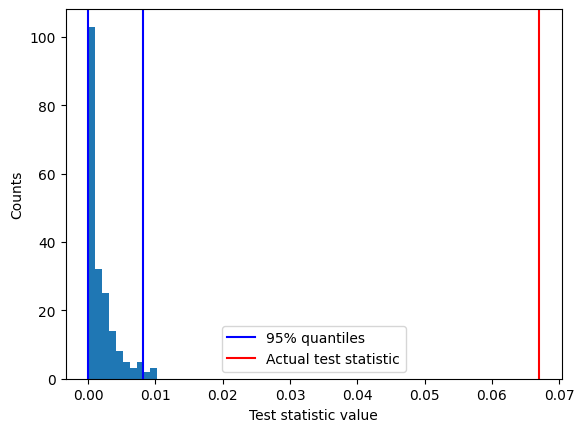

In [11]:
# IMPLEMENT: use squared test statistic
simple_statistic_squared = lambda X,Y: simple_statistic(X,Y,squared=True)

# visualise test
statistics = two_sample_permutation_test(simple_statistic_squared, X, Y, num_permutations)
my_statistic = simple_statistic_squared(X,Y)
plot_permutation_samples(statistics, my_statistic)

### Alternative distribution via explicit simulation

As a caveat, please note that the test statistic itself has a distribution under the alternative hypothesis ($P_X \neq P_Y$), and that our computed test statistic is only a single sample from this distribution.
In practice, it is unfortunately not possible to look at the distribution of the test under the alternative, as this would require a way to generate more data.
We can try this for a synthetic example where we have infinite data though.

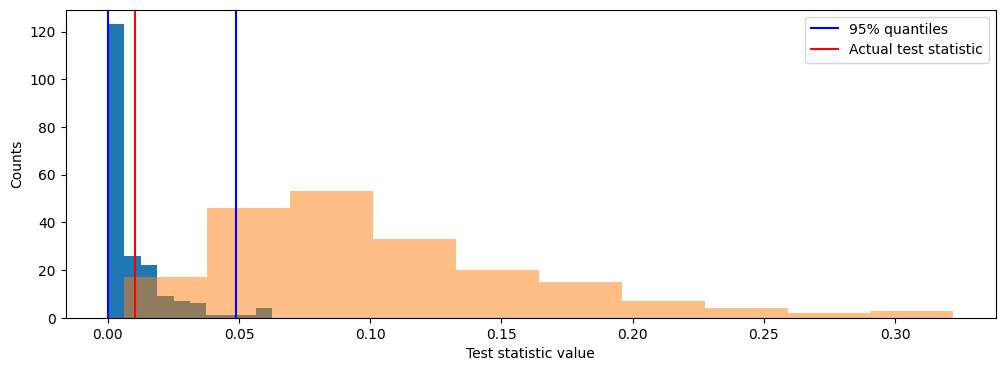

In [12]:
np.random.seed(0)

# we make a model where the null distribution is false
shift = .3
N = 200
X = np.random.randn(N)
Y = np.random.randn(N)+shift

statistics_null = two_sample_permutation_test(simple_statistic_squared, X, Y, num_permutations)
my_statistic = simple_statistic_squared(X,Y) # this is a single sample from the alternative

statistics_alt = np.zeros(num_permutations)
for i in tqdm(range(num_permutations)):
    # IMPLEMENT: generate more data from the alternative
    X = np.random.randn(N)
    Y = np.random.randn(N)+shift

    statistics_alt[i] = simple_statistic_squared(X,Y)

plt.figure(figsize=(12,4))
plot_permutation_samples(statistics_null, my_statistic)
plt.hist(statistics_alt, alpha=0.5);

As you can see, even though most of the alternative distribution far larger than the null, we can be unlucky: there are datasets for which the test would not reject the null simply by chance -- we only have a single draw from the alternative.
With this fixed seed, it turns out that we have been unlucky and would have not rejected the null hypothesis even it is not true.
You could play with the sample size and observe how this impacts the position of the alternative distribution (and as such the test power).

Let's try the test on another dataset.

Means: -0.05499658 0.027213123
Standard deviations: 1.046988 0.9609663


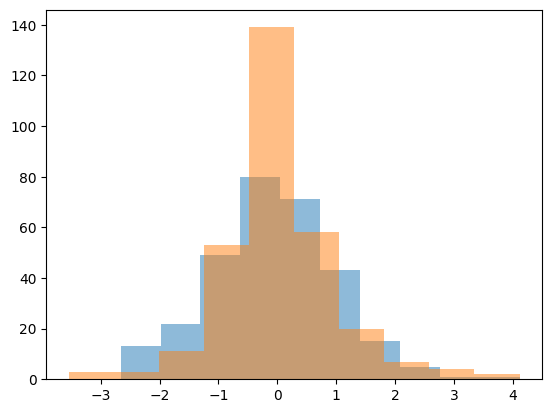

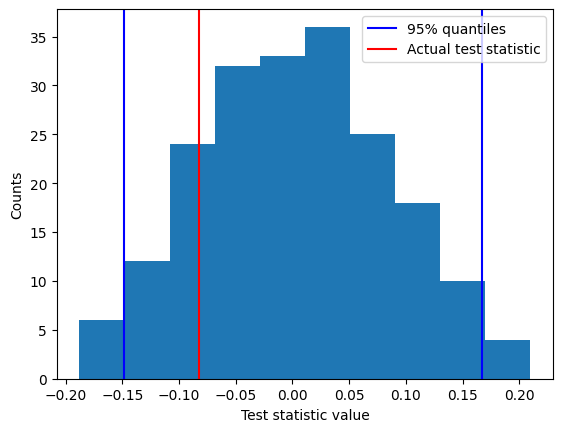

In [13]:
data = np.load("./data/almost_simple.npz")
X = data["X"]
Y = data["Y"]
plt.hist(X, alpha=0.5)
plt.hist(Y, alpha=0.5)

# IMPLEMENT: print mean and std deviation of data
print("Means:", np.mean(X), np.mean(Y))
print("Standard deviations:", np.std(X), np.std(Y))

my_statistic = simple_statistic(X,Y)
statistics = two_sample_permutation_test(simple_statistic, X, Y, num_permutations)

plt.figure()
plot_permutation_samples(statistics, my_statistic)

And now for the squared test statistic

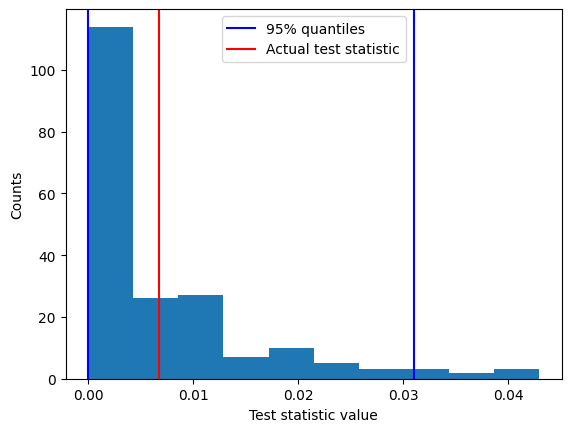

In [14]:
# IMPLEMENT: visualize test for squared statistic
simple_statistic_squared = lambda X,Y: simple_statistic(X,Y,squared=True)
statistics = two_sample_permutation_test(simple_statistic_squared, X, Y, num_permutations)
my_statistic = simple_statistic_squared(X,Y)
plot_permutation_samples(statistics, my_statistic)

As we can see, both test statistics essentially have no chance in distinguishing this data.
(althogh keep in mind we could have been unlucky as outlined above).
For now, let's just assume we only have a single dataset to compute the test.

## Quadratic time MMD



We have already seen the quadratic time MMD: it was the squared difference of the sample means above, if we had used a linear kernel (where the feature space embedding is the identity function).
This test wasn't able to distinguish the above distributions, but let's try a different kernel.

We will use the unbiased statistic here, defined as
$$ 
\frac{1}{n(n-1)}\sum_{i=1}^n\sum_{j\neq i}^m k(x_i,x_j) + \frac{1}{m(m-1)}\sum_{i=1}^n\sum_{j\neq i}^mk(y_i,y_j) -2\frac{1}{nm}\sum_{i=1}^n \sum_{j=1}^m k(x_i,y_j)
$$
See the slides for more details.

### Kernels


We first need to implement a kernel function.
Though we could use a framework to do this for us, it is quite instructive to do this ourselves (at least once).

We will start with a Gaussian kernel
$$
k(x,y) = \exp \left( - \frac{||x-y||_2^2}{\sigma}\right)
$$
with some bandwidth parameter $\sigma$ (note there are many different parametrizations!).

This kernel is translation invariant, and like many other kernels, it is defined in terms of pairwise (Euclidean) distances between the data.
Let's implement it this way so we can easily try other kernels that are translation invariant.

In [6]:
from scipy.spatial.distance import squareform, pdist, cdist

def sq_distances(X,Y=None):
    """
    If Y=None, then this computes the distance between X and itself
    """
    assert(X.ndim==2)

    # IMPLEMENT: compute pairwise distance matrix. Don't use explicit loops, but the above scipy functions
    # if X=Y, use more efficient pdist call which exploits symmetry
    if Y is None:
        sq_dists = squareform(pdist(X, 'sqeuclidean'))
    else:
        assert(Y.ndim==2)
        assert(X.shape[1]==Y.shape[1])
        sq_dists = cdist(X, Y, 'sqeuclidean')

    return sq_dists

def gauss_kernel(X, Y=None, sigma=1.0):
    """
    Computes the standard Gaussian kernel k(x,y)=exp(- ||x-y||**2 / (2 * sigma**2))

    X - 2d array, samples on left hand side
    Y - 2d array, samples on right hand side, can be None in which case they are replaced by X

    returns: kernel matrix
    """

    # IMPLEMENT: compute squared distances and kernel matrix
    sq_dists = sq_distances(X,Y)
    K = np.exp(-sq_dists / (2 * sigma**2))
    return K

# IMPLEMENT
def linear_kernel(X, Y):
    return np.dot(X, Y.T)

With the kernel at hand, we can implement the quadratic time MMD statistic as a function of the kernel.

In [7]:
def quadratic_time_mmd(X,Y,kernel):
    assert X.ndim == Y.ndim == 2
    K_XX = kernel(X,X)
    K_XY = kernel(X,Y)
    K_YY = kernel(Y,Y)

    n = len(K_XX)
    m = len(K_YY)

    # IMPLEMENT: unbiased MMD statistic (could also use biased, doesn't matter if we use permutation tests)
    np.fill_diagonal(K_XX, 0)
    np.fill_diagonal(K_YY, 0)
    mmd = np.sum(K_XX) / (n*(n-1))  + np.sum(K_YY) / (m*(m-1))  - 2*np.sum(K_XY)/(n*m)
    return mmd

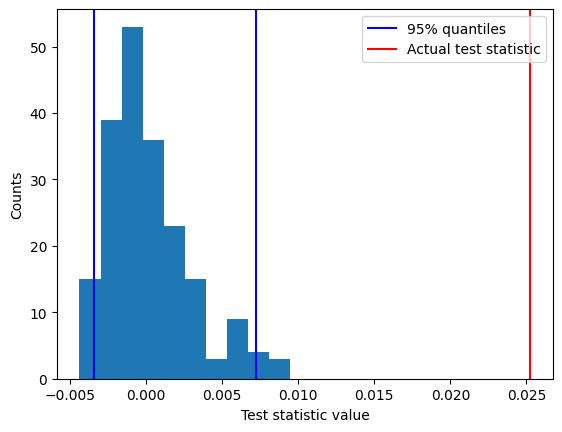

In [17]:
my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=0.3)
my_mmd = lambda X,Y : quadratic_time_mmd(X[:,np.newaxis],Y[:,np.newaxis], my_kernel)

statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)

plot_permutation_samples(statistics, my_statistic)

This seems much better: the Gaussian kernel allows us to very clearly distinguish the two distributions.

Now let us try the MMD with a linear kernel and compare it to the above.
In particular, compare (and think about) the relationship to the simple squared mean difference statistic we computed above.

In [18]:
# test equivalence linear kernel with unbiased statistic vs squared difference of means
num_samples = 10000
test1 = np.random.randn(num_samples) + 1
test1 = test1[:,np.newaxis]
test2 = np.random.randn(num_samples) + 5
test2 = test2[:,np.newaxis]
stat1 = simple_statistic(test1[:,0], test2[:,0], squared=True)
stat2 = quadratic_time_mmd(test1, test2, linear_kernel)
stat1, stat2

(16.14073786916104, 16.14053790596624)

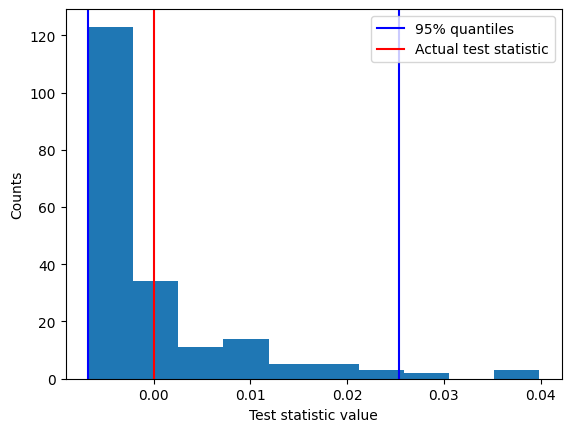

In [19]:
# IMPLEMENT: visualize test using linear kernel
my_kernel = lambda X,Y : linear_kernel(X,Y)
my_mmd = lambda X,Y : quadratic_time_mmd(X[:,np.newaxis],Y[:,np.newaxis], my_kernel)

statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)

plot_permutation_samples(statistics, my_statistic)

This is almost the same result as we had for doing the simple squared statistic above.

### Alternative methods to estimate the null distribution

There are multiple other way to get our hands on the distribution of the MMD test statistic under the null hypothesis.

We know that asymptotically, the distribution is an infinite sum of Chi-square variables -- intractable unfortunately.
Techniques to approximate it include

* moment matching using a Gamma distribution: fast, but doesn't result in a consistent test
* a spectral approximation: use Eigenvalues of the kernel matrix to sample from the null distribution in closed form. Costly (cubic!) for large sample sets.
* wild-bootstrap: a technique used for correlated samples that is similar to permuting
* linear time statistics: for those, one can often show that the null distribution is Gaussian and its variance can be estimated in closed form.

We do not cover those here since they require some more details.
The permutation test, while potentially slower, is easy to understand and works for most applications (if implemented well).

Some resources:
* [a Shogun notebook](http://www.shogun-toolbox.org/notebook/latest/mmd_two_sample_testing.html), old but contains many null approximation methods
* Linear time tests based on analytic function comparisons (see notes at end of section)

## MMD witness function in the RKHS

One nice feature of the MMD is that we can see where the density functions are different via querying the (empirical) MMD witness function.
This is just the difference of the empirical mean embeddings in the RKHS and thus computable (remember the MMD is the RKHS norm of this witness function).
See the slides for details.

$$f^*(\cdot)=\hat \mu_X(\cdot) - \hat \mu_Y(\cdot) $$

Let's define a grid and evaluate the witness function on it to see where X and Y differ most.

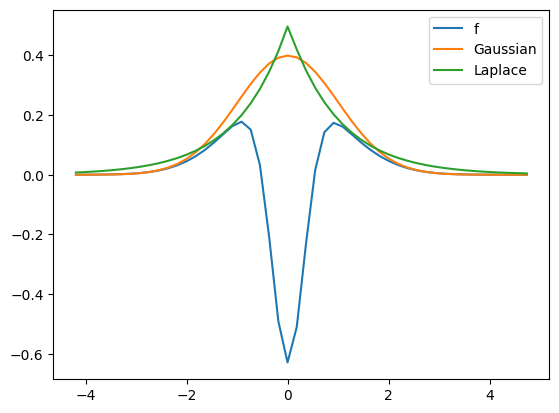

In [42]:
X = np.random.normal(size=100000, scale=1.0)
Y = np.random.laplace(size=100000, scale=0.1)

grid = np.linspace(np.min(X), np.max(X))

my_kernel = lambda X,Y : gauss_kernel(X,Y, sigma=0.3)

# IMPLEMENT: evaluate MMD witness function on grid
phi_X = np.mean(my_kernel(X[:,np.newaxis], grid[:,np.newaxis]), axis=0)*1
phi_Y = np.mean(my_kernel(Y[:,np.newaxis], grid[:,np.newaxis]), axis=0)
witness = phi_X-phi_Y

plt.plot(grid, witness, label="f")
# compute gaussian pdf based on grid domain
pdf_x = np.exp(-grid**2/2)/np.sqrt(2*np.pi)
# compute laplace pdf based on grid domain
pdf_y = np.exp(-np.abs(grid))/2

plt.plot(grid, pdf_x, label="Gaussian")
plt.plot(grid, pdf_y, label="Laplace")
plt.legend()

# plt.hist(X, alpha=0.5, density=True)
# plt.hist(Y, alpha=0.5, density=True);


3.928633669346844 1.9751057331918775
4.035992805478751 2.0458872734754885


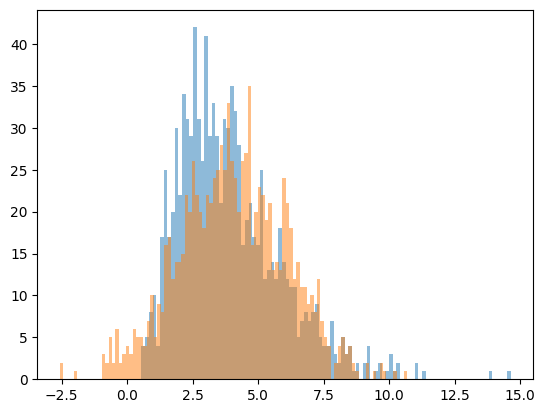

In [21]:
# IMPLEMENT (optional): try mix and matching kernels and data sources
# e.g. try a periodic kernel on data that differs in frequency space
from scipy.stats import laplace, norm, lognorm, levy, gamma

mean = 4

X2 = gamma.rvs(mean, loc=0., scale=1., size=1000)
plt.hist(X2, bins=100, alpha=0.5);
print(np.mean(X2), np.std(X2))

Y2 = norm.rvs(loc=mean, scale=np.sqrt(mean), size=1000)
plt.hist(Y2, bins=100, alpha=0.5);
print(np.mean(Y2), np.std(Y2))

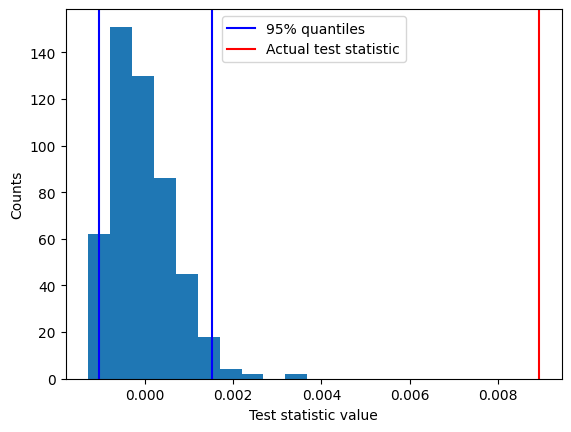

In [22]:
num_permutations = 500
my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=0.3)
my_mmd = lambda X,Y : quadratic_time_mmd(X[:,np.newaxis],Y[:,np.newaxis], my_kernel)

statistics = two_sample_permutation_test(my_mmd, X2, Y2, num_permutations)
my_statistic = my_mmd(X2,Y2)

plot_permutation_samples(statistics, my_statistic)

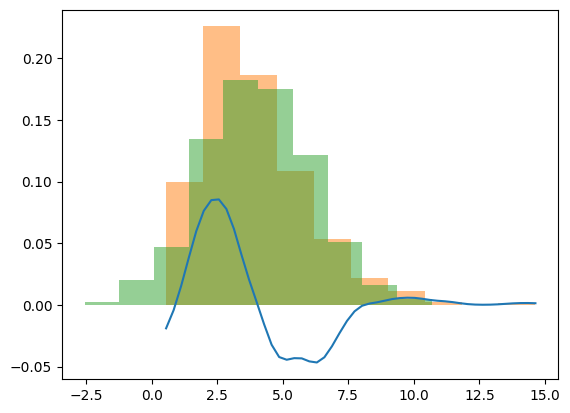

In [23]:
grid = np.linspace(np.min(X2), np.max(X2))

my_kernel = lambda X,Y : gauss_kernel(X,Y, sigma=0.5)

# IMPLEMENT: evaluate MMD witness function on grid
phi_X = np.mean(my_kernel(X2[:,np.newaxis], grid[:,np.newaxis]), axis=0)
phi_Y = np.mean(my_kernel(Y2[:,np.newaxis], grid[:,np.newaxis]), axis=0)
witness = phi_X-phi_Y

plt.plot(grid, witness)

plt.hist(X2, alpha=0.5, density=True)
plt.hist(Y2, alpha=0.5, density=True);

As we can see, the witness function is positive where X as a higher density than Y, and negative vice versa.
It is zero where both densities match.
Intuitively, the RKHS norm of this function can only be zero if the densities match everywhere, and it grows as the densities differ on more and more points in their support.
Of course, this kind of visualization only works in few dimensions.

## Notes on efficient implementations
Note that the above implemention of the MMD, and in particular the permutation test, is extremelty inefficient since the kernel matrix is re-computed in every iteration of the permutation test (and the data is copied around for concatenation as well).
We could precompute it once, but then we still would be required to permute it multiple times.

We have written a multi-threaded version in C++ that does not permute the matrix, but simply traverses it multiple times, which makes the algorithm L2 cache friendly and therefore hundreds of times faster.
See:
* http://shogun.ml for the toolbox
* http://shogun.ml/examples/latest/examples/statistical_testing/quadratic_time_mmd.html for an API example
* http://www.shogun-toolbox.org/notebook/latest/mmd_two_sample_testing.html for a complex demo in Python
* https://arxiv.org/abs/1611.04488 for a paper with performance details

We will use Shogun for a larger example below.
You could time our handwritten implementation against it, or you can tune the Python implementation and try to beat it ;)

## Kernel learning (aka which kernel parameter to choose?)

We have seen that the Gaussian kernel above increased the power of the test.
But what happened if we chose a wrong kernel parameter?
Let's pick a bad one and see.

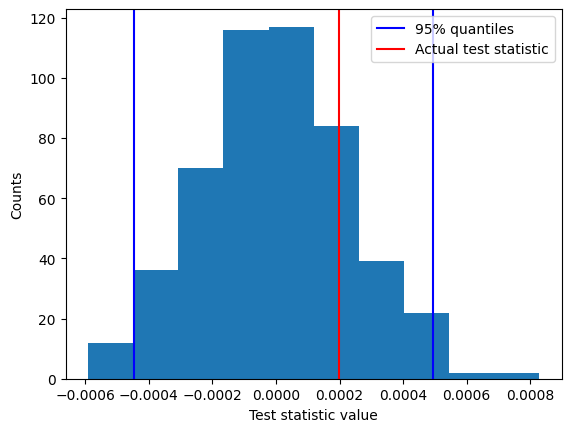

In [24]:
my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=0.001)
my_mmd = lambda X,Y : quadratic_time_mmd(X[:,np.newaxis],Y[:,np.newaxis], my_kernel)

statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)
plot_permutation_samples(statistics, my_statistic)

The output is quite different, the performance of kernel tests indeed crucially depends on the chosen parameters.
How to chose those in practice?

For simple datasets, there is a heuristic rule to chose the parameter of a Gaussian kernel: using the median of the pairwise distances of the data.
See https://arxiv.org/abs/1707.07269 for details.

In [25]:
def gaussian_kernel_median_heuristic(Z):
    # IMPLEMENT: compute the median of the pairwise distances in Z
    # (not taking zero distance between identical samples (diagonal) into account)
    sq_dists = sq_distances(Z)
    np.fill_diagonal(sq_dists, np.nan)
    sq_dists = np.ravel(sq_dists)
    sq_dists = sq_dists[~np.isnan(sq_dists)]
    median_dist = np.median(np.sqrt(sq_dists))

    return np.sqrt(median_dist/2.0) # our kernel uses a bandwidth of 2*(sigma**2)

sigma_median = gaussian_kernel_median_heuristic(np.vstack((X[:,np.newaxis],Y[:,np.newaxis])))
print(sigma_median)

0.6585612327494343


Note that we could probably get away with sub-sampling the data to compute pair-wise distances to speed up computing the heuristic, as it stabilizes quickly.
In addition, we should probably re-use the pairwise distances when computing the kernel matrix; again, see Shogun.

Let's try the heuristic for the statistical test.

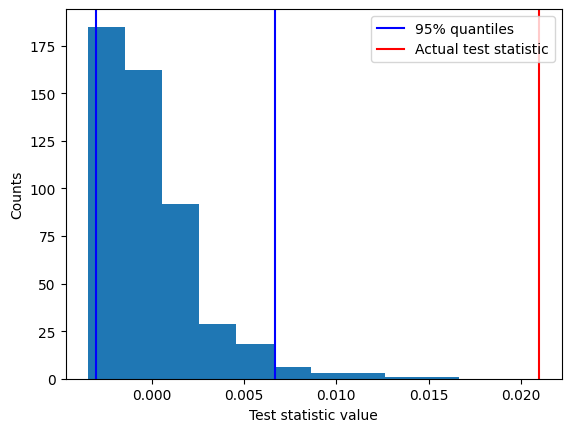

In [26]:
my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=sigma_median)
my_mmd = lambda X,Y : quadratic_time_mmd(X[:,np.newaxis],Y[:,np.newaxis], my_kernel)

statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)
plot_permutation_samples(statistics, my_statistic)

This worked great!
But it doesn't always.

Let's try the median heuristic on the following dataset, referred to as Gaussian blobs, see https://papers.nips.cc/paper/4727-optimal-kernel-choice-for-large-scale-two-sample-tests.

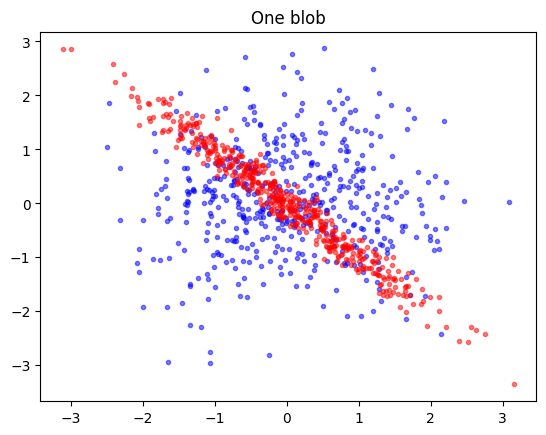

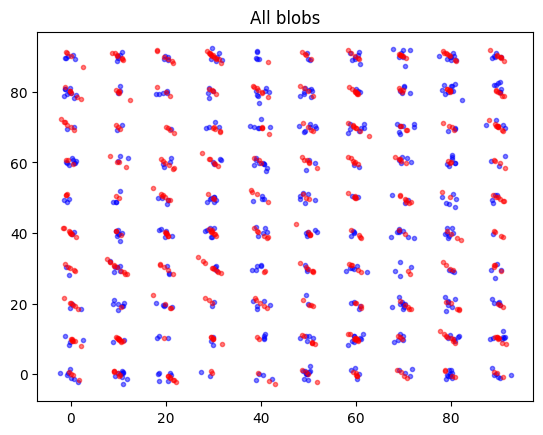

In [27]:
data = np.load("./data/blobs_zoomed.npz")
X = data["X"]
Y = data["Y"]
plt.plot(X[:,0], X[:,1], 'b.', alpha=0.5)
plt.plot(Y[:,0], Y[:,1], 'r.', alpha=0.5)
plt.title("One blob")

plt.figure()
data = np.load("./data/blobs.npz")
X = data["X"]
Y = data["Y"]
plt.plot(X[:,0], X[:,1], 'b.', alpha=0.5)
plt.plot(Y[:,0], Y[:,1], 'r.', alpha=0.5);
plt.title("All blobs");

Clearly, the two distributions are very different.
On the grid, the scale at which they differ, however, is somewhat invisible from the median heuristic, which looks at global scaling of the data.

median bw/sigma: 51.60189981691304 / 5.079463545341823


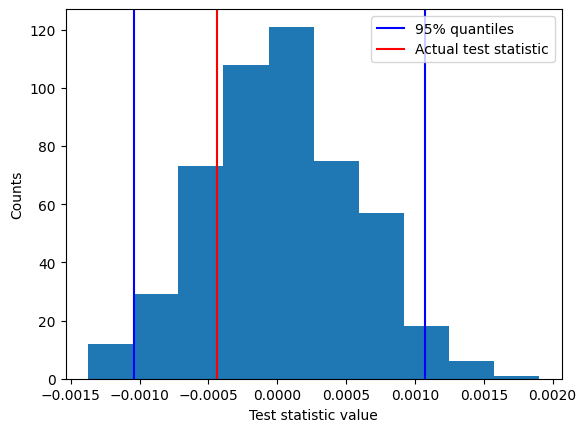

In [28]:
sigma_median = gaussian_kernel_median_heuristic(np.vstack((X,Y)))
print("median bw/sigma:", 2*(sigma_median**2), "/", sigma_median)

# IMPLEMENT: visualize test using median heuristic
my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=sigma_median)
my_mmd = lambda X,Y : quadratic_time_mmd(X,Y, my_kernel)

statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)

plot_permutation_samples(statistics, my_statistic)

Somehow, the median distance does not really represent the scale on which the two distribution are differing here (they clearly do!).
We have figure out how to fix that though.

### Using cross-validation to select a single kernel parameter

As a modern ML scientist, your first reflex might be to just try a bunch of different kernel parameters, and compute a cross-validation estimate of the test power.
This involves computing the test for the "training partitions" of every fold, and average the number of rejections.
Let's start with that.
Note that we have to use a different "training" dataset to learn the kernel -- otherwise the test would over-fit.

In [29]:
# Let's start with few values
log_sigmas = np.array([-5, 0., 10])

num_folds = 5
data = np.load("./data/blobs2.npz")
X_learn = data["X"]
Y_learn = data["Y"]

from sklearn.model_selection import KFold

test_powers = np.zeros(len(log_sigmas))
np.random.seed(0)

for i, log_sigma in tqdm(list(enumerate(log_sigmas))):
    # IMPLEMENT: define kernel and mmd
    my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=10**log_sigma)
    my_mmd = lambda X,Y : quadratic_time_mmd(X,Y, my_kernel)
    kf = KFold(n_splits=num_folds, shuffle=True)

    rejects = []
    for train, _ in  kf.split(X_learn):
        # IMPLEMENT: split data into train and test folds
        X_learn_train = X_learn[train]
        Y_learn_train = Y_learn[train]

        # IMPLEMENT: compute test statistic and null distribution, use prog_bar=False
        statistics = two_sample_permutation_test(my_mmd, X_learn_train, Y_learn_train, num_permutations, prog_bar=False)
        my_statistic = my_mmd(X_learn_train, Y_learn_train)

        # IMPLEMENT: compute p-value as the quantile of the test statistic in the null distribution
        p_value = np.mean(my_statistic <= np.sort(statistics))
        rejects += [p_value<0.05]

    test_powers[i] = np.mean(rejects)

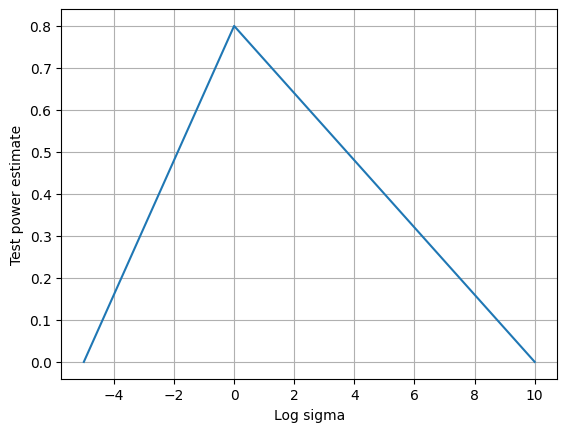

In [30]:
plt.plot(log_sigmas, test_powers)
plt.xlabel("Log sigma")
plt.ylabel("Test power estimate")
plt.grid(True)

This seems to give us an idea of which kernel parameter is better.
Unfortunately, this approach is quite costly and noisy.
In reality, we would also want to use more folds, repeat the x-validation, and try out more kernel parameters (play with it and you will see).

We could try one of the faster approximations for the null distribution mentioned above, for example the moment matching Gamma approach.
This would speed up the procedure, however, the Gamma approximation has its limits in how accurate it is, especially for extreme values of the kernel.

Instead, we will do something better.

### Optimal kernel via maximising the ratio of mmd and its variance, see https://arxiv.org/abs/1611.04488

We have seen that estimating the test power using cross-validation is a bit messy; it is also not differentiable.

Luckily, there is a closed form criterion that acts as a surrogate for the test power: the MMD divided by its variance.
You have seen in the slides that maximising this directly maximises the power of the statistical test -- without ever computing the test.

Long story short, you can

1. Pick a training set (not the one you use for performing the test, to avoid overfitting)
2. Choose the kernel that maximises the value of the MMD, divided by its standard variance
3. Enjoy a test that has higher power

As implementing the variance of the MMD estimator is slightly more complicated, we have provided a TensorFlow implementation for you (so we can later automagically differentiate it).
Feel free to examine the imported code in `mmd.py`.

(Note that the provided implementation uses a biased MMD statistic, and as such produces slightly different numbers).

In [31]:
# provided implementation
import tensorflow as tf
import mmd

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print("MMD and ratio:", sess.run(mmd.rbf_mmd2_and_ratio(X,Y, sigma=sigma_median)))


ModuleNotFoundError: No module named 'tensorflow'

As seen above, the most naive way to select a kernel to to come up with a number of baseline kernels, then simply compute the ratio of MMD and standard deviation for all of them, and finally to pick the kernel with the largest ratio.
Remember it is important to do this on a separate "training" dataset.

best sigma: 0.21544346900318834


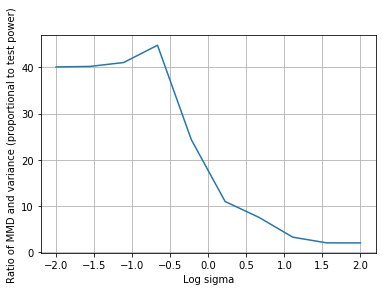

In [ ]:
data = np.load("./data/blobs2.npz")
X_learn = data["X"]
Y_learn = data["Y"]

# sigma = 10**log_sigma
log_sigmas = np.linspace(-2, 2,10)

ratios = np.empty(len(log_sigmas))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # IMPLEMENT: compute ratio for every sigma
    for i, log_sigma in tqdm(list(enumerate(log_sigmas))):
        current_ratio = sess.run(mmd.rbf_mmd2_and_ratio(X_learn,Y_learn, sigma=10**log_sigma))[1]
        ratios[i] = current_ratio

plt.plot(log_sigmas, ratios)
plt.grid(True)
plt.xlabel("Log sigma")
plt.ylabel("Ratio of MMD and variance (proportional to test power)")

print("best sigma:", 10**log_sigmas[np.argmax(ratios)])

This was much faster, even for more parameters to try.

The curve looks very much like those obtained when cross-validating kernel-parameters for kernel machines (like a support vector machine): you make the model/test more and more complex (bandwidth smaller), until it hits a sweet spot (peak), and after which it starts overfitting (ratio decreasing).
Let's try out how it worked.

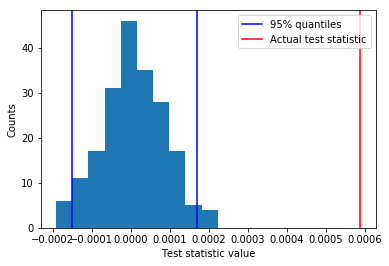

In [ ]:
sigma_opt = 0.215

# IMPLEMENT: visualise test for best sigma
my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=sigma_opt)
my_mmd = lambda X,Y : quadratic_time_mmd(X,Y, my_kernel)

statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)
plot_permutation_samples(statistics, my_statistic)

Victory!

### Gradient descent
Now, what if we have more than one kernel parameter?
Trying out all the different combinations is not the best idea.
Instead, we can take a deep learning artisan's mindset and do gradient descent.
That is, we maximize the ratio of MMD to standard deviation as a function of the kernel parameters (differentiable!), we could even do this in mini-batches.

The implementation of the ratio is quite tricky (you might have checked the imported code).
Differentiating it would be a nightmare, but luckily in 2018 we have tools at hand that allow us to do this.

### GANs

Moving to the context of training GANs (Generative adversarial networks).
Assume someone came to you with a new GAN, which generates some realistic looking images, supposedly indistinguishable from the images used to train the GAN.

Let's assume that person said (https://arxiv.org/abs/1606.03498)
> On MTurk, annotators were able to distinguish
samples in 52.4% of cases (2000 votes total), where 50% would be obtained by random
guessing. Similarly, researchers in our institution were not able to find any artifacts that would allow
them to distinguish samples.

Let's see what the kernel MMD thinks about this.
We will use a slightly different kernel than before: an ARD kernel.
This one that scales each of the $D$ input dimensions by a parameter, and then uses a standard Gaussian kernel (unit bandwidth) on top of that.
$$ k(x,y) = \exp\left(-\sum_d^D (x_d/\sigma_d - y_d/\sigma_d)^2\right) $$
Again, we have implemented this for you in `mmd.py`, feel free to see how.

We begin with visualizing the data, and splitting it into train and test set.

Image dimensions: 28x28=784


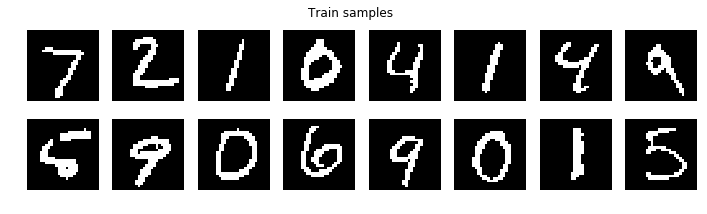

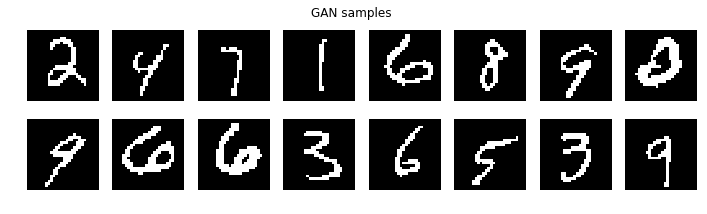

In [ ]:
X = np.load("./data/samples-to-compare.npz")["target"]
# before fitting the model, we binarized the images
X[X<0.5]=0
X[X>=0.5]=1

Y = np.load("./data/samples-to-compare.npz")["model"]

plt.figure(figsize=(12,3))
plt.suptitle("Train samples")

for i in np.arange(0,16):
    plt.subplot(2,8,i+1)
    plt.imshow(X[i],cmap='gray')
    plt.axis('off')
plt.figure(figsize=(12,3))
plt.suptitle("GAN samples")
for i in np.arange(0,16):
    plt.subplot(2,8,i+1)
    plt.imshow(Y[i],cmap='gray')
    plt.axis('off')

# split off a training set, reshape to vectors
N = len(X)
assert len(X) == len(Y)
size = X.shape[1]
size2 = size**2
assert size2 == X.shape[2]**2
half = int(N/2)
X_learn = X[half:].reshape(half,size2)
Y_learn = Y[half:].reshape(half,size2)
X = X[:half].reshape(half,size2)
Y = Y[:half].reshape(half,size2)

print("Image dimensions: %dx%d=%d" % (size, size, size2))

Now we have some code to compute the ratio we want to optimize, and make TensorFlow's Adam optimizer do the rest for us, i.e optimizing the bandwidth variables, $28^2$ of them.

Note: this is a very simplistic implementation that might suffer from all sorts of problems.
In practice, we would pay more careful attention to the optimization scheme.

In [ ]:
sigmas = tf.Variable(np.ones(X_learn.shape[1]), dtype=np.float32, name="sigmas")

# provided function. note we are using the "training" dataset here.
ratio = mmd.ard_mmd2_and_ratio(X_learn,Y_learn, bws=sigmas)[1]

# IMPLEMENT: set up adam optimizer tensorflow op to maximise the ratio
learning_rate = 0.5
optimizer = tf.train.AdamOptimizer(learning_rate)
minimize = optimizer.minimize(-ratio)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    print("start,", "ratio:", sess.run(ratio))

    for step in range(20):
        # IMPLEMENT: run optimizer and update best found sigmas so far
        sess.run(minimize)
        print("step,", "ratio:", sess.run(ratio))
        best_sigmas = sess.run(sigmas)
    print("done, ratio:", sess.run(ratio))

start, ratio: 0.1268358
step, ratio: 0.1310806
step, ratio: 0.14533705
step, ratio: 0.17821728
step, ratio: 0.24888371
step, ratio: 0.39294672
step, ratio: 0.6644053


KeyboardInterrupt: 

As we now have learnt one bandwidth per pixel, we can visualise the scaled data to see what the resulting test focusses on.
Note that we do this on the actual test data, while we learned the weights on the training data.

In [ ]:
# IMPLEMENT: scale images according to sigmas
X_scaled = (X/best_sigmas)
Y_scaled = (Y/best_sigmas)

plt.suptitle("Train samples")
plt.figure(figsize=(12,3))
for i in np.arange(0,16):
    plt.subplot(2,8,i+1)
    plt.imshow(X_scaled[i].reshape(size, size),cmap='gray')
    plt.axis('off')
plt.figure(figsize=(12,3))
plt.suptitle("GAN samples")
for i in np.arange(0,16):
    plt.subplot(2,8,i+1)
    plt.imshow(Y_scaled[i].reshape(size, size),cmap='gray')
    plt.axis('off')
plt.figure()
plt.title("ARD weights")
plt.imshow(best_sigmas.reshape(size,size), 'magma')
plt.colorbar()
plt.axis('off');

As we can see, there seem to be pixel level artifacts that the test focuses on.
As it turns out, focusing on those allows the test to fully distinguish training samples from GAN samples.

Since our above implementation for the MMD permutation test is very inefficient, we don't use it here to perform the full test -- it would take too long.
You can use the below Shogun snippet to perform the test much more quickly.

In [ ]:
import shogun as sg
sg.get_global_parallel().set_num_threads(4)

sigma = 1
kernel_width = 2 * sigma**2
mmd = sg.QuadraticTimeMMD()
mmd.set_p(sg.RealFeatures(X_scaled.T.astype(np.float64))) # shogun uses column major format
mmd.set_q(sg.RealFeatures(Y_scaled.T.astype(np.float64)))
mmd.set_kernel(sg.GaussianKernel(10, kernel_width))

mmd.set_num_null_samples(num_permutations)
statistics = mmd.sample_null()
my_statistic = mmd.compute_statistic()
plot_permutation_samples(statistics, my_statistic)

In [ ]:
# IMPLEMENT (optional): how does this compare to all weights being one.
sigma = 1
kernel_width = 2 * sigma**2
mmd = sg.QuadraticTimeMMD()
mmd.set_p(sg.RealFeatures(X.T.astype(np.float64)))
mmd.set_q(sg.RealFeatures(Y.T.astype(np.float64)))
mmd.set_kernel(sg.GaussianKernel(10, kernel_width))

mmd.set_num_null_samples(num_permutations)
statistics = mmd.sample_null()
my_statistic = mmd.compute_statistic()
plot_permutation_samples(statistics, my_statistic)

Here we see that the unscaled features already allow the test to distinguish the distribution quite well.
The scaled version above, however, is a much more powerful test.

### Notes

Have much more data? Try the linear time versions of the tests
* https://arxiv.org/abs/1605.06796
* https://arxiv.org/abs/1506.04725


Need faster implementations (of the quadratic time MMD tests)
* use Shogun!

# Independence testing

Let's move on to independence testing.
Here, the data we observe is in pairs $(x_i,y_i)\sim P_{XY}$..
The null hypothesis is that the two sets of samples come from independent distributions: $P_{XY} = P_X\cdot P_Y$.

We will use the HSIC, which you can think of as the MMD between the joint distribution $P_{XY}$ and the product of the marginal distributions $P_X P_Y$. 
Clearly, if those are different, then the samples cannot be independent.

See the slides for more details.

## Quadratic time test statistic

Let's kick of with implementing the quadratic time version of the HSIC statistic.

$$ \frac{1}{n^2}\text{Trace}(KL) $$

where $K$ and $L$ are centered kernel matrices of the samples from the two distribution respectively.
(Note that one can center a kernel matrix via multiplying it with a centering matrix $H=I-\frac{1}{n}\mathbf{1}\mathbf{1}^\top$.)

As our kernel will quite expensive to be computed, we here write a version that accepts precomputed kernel matrices rather than a kernel function, and we will permute this kernel matrix for the permutation test.
We implement the test statistic as a function of kernel matrices, and with an option to permute the matrices before computing the statistic (for approximating the null distribution).

Note that the permutation for dependence testing is different from two-sample testing: in two sample testing, we could just permute the joint kernel matrix (as there is a kernel between $X$ and $Y$).
For dependence testing, however, the kernel only is defined between $X$ and itself and $Y$ and itself.
"Breaking" any potential structure therefore means that we need to shuffle the samples within $X$ and within $Y$ so that any potential pairs $(x_i,y_i)$ do not occur together anymore.

In [ ]:
def HSIC(K_XX, K_YY, permute=False):
    assert len(K_XX) == len(K_YY)
    N = len(K_XX)
    if permute:
        # IMPLEMENT: permute the kernel matrices for X and Y
        inds_X = np.random.permutation(len(K_XX))
        inds_Y = np.random.permutation(len(K_YY))
        K_XX_ = K_XX[inds_X, :][:, inds_X]
        K_YY_ = K_YY[inds_Y, :][:, inds_Y]
    else:
        K_XX_ = K_XX
        K_YY_ = K_YY

    # IMPLEMENT: HSIC statistic
    H = np.eye(N) - 1.0/N
    statistic = np.trace(K_XX_.dot(H).dot(K_YY_.dot(H))) / (N**2)
    return statistic

## Simple example

Let's start with a simple dataset.

In [ ]:
data = np.load("./data/hsic2.npz")
X = data["X"]
Y = data["Y"]
plt.plot(X,Y,'.')
plt.axis('equal')
plt.grid(True)

Clearly, there is some very simple dependence going on.
The first thing a statistician in the field would do is of course to check for correlation.

In [ ]:
# IMPLEMENT: produce a seaborn pairplot to show the correlation between X and Y
print("Correlation between X and Y:", np.corrcoef(X,Y)[0,1])

The correlation is very low.
A kernel test for independence is more powerful, even with a bandwidth parameter chosen by the median heuristic.

In [ ]:
# IMPLEMENT: compute kernel matrices using the median heuristic
sigma_median = gaussian_kernel_median_heuristic(np.vstack((X[:,np.newaxis],Y[:,np.newaxis])))
my_kernel = lambda X,Y : gauss_kernel(X[:,np.newaxis],Y[:,np.newaxis],sigma=sigma_median)
K_XX = my_kernel(X,X)
K_YY = my_kernel(Y,Y)
K_XY = my_kernel(X,Y)

statistics = np.empty(num_permutations)
for i in tqdm(range(num_permutations)):
    # IMPLEMENT: compute HSIC statistic with permuted matrices
    statistics[i] = HSIC(K_XX, K_YY, permute=True)

# IMPLEMENT: visualise test
my_statistic = HSIC(K_XX, K_YY)
plot_permutation_samples(statistics, my_statistic)

Victory once again.

## European parliament documents translations and string kernels

We will now do a slightly more elaborate test that involves some very mild NLP.
More precisely we will analyze dependence between documents.
We will use transcripts of the Canadian parliament's house debates, downloaded from [here](https://www.isi.edu/natural-language/download/hansard/).
Those consist of pairs of French and English transcripts.

Our question here is whether we can detect this supposedly strong dependence structure using the kernel HSIC.
Note that this approach does not rely on attempting to translate the documents, but rather on comparing within-document structure. 
HSIC compares the self-similarity within the English documents with self-similarity of the French ones.

In a first step, we load the data, and store the transcript of each session into lists X and Y, for English and French respectively.
We don't do any sophisticated preprocessing here, but feel free to make this more elaborate.

In [ ]:
# download english and french stopwords (optional)
try:
    import nltk
    from nltk.corpus import stopwords
    nltk.download('stopwords');
    stop_english = set(stopwords.words("english"))
    stop_french = set(stopwords.words("french"))
except Exception:
    stop_english = set()
    stop_french = set()

In [ ]:
from glob import glob
import re

X = []
Y = []
for fname in tqdm(sorted(list(glob("transcripts/hansard.36.1.house.debates.*.*")))):
    is_french = fname.endswith("f")
    is_english = fname.endswith("e")

    if not (is_english or is_french):
        continue

    with open(fname, "r", encoding='latin-1') as f:
        # some very very simple preprocessing, could be more elaborate with special characters
        content = "".join(f.readlines())
        if is_english:
            letters_only = re.sub("[^a-zA-Z]", " ", content)
        elif is_french:
            letters_only = re.sub("[^a-zA-Z\'ÁÀÂÉÈÊéèáàêâúùûÚÙÛçîô']", " ", content)
        words = letters_only.lower().split()

        if is_english:
            stops = stop_english
        elif is_french:
            stops = stop_french
        meaningful_words = [w for w in words if not w in stops]

        result = " ".join(meaningful_words)

        if fname.endswith("e"):
            X += [result]
        else:
            Y += [result]
N = len(X)
assert N == len(Y)

Let's look at some excerpts.

In [ ]:
print(X[0][-100:])
print(Y[0][-100:])

Next, we are going to construct a string kernel, a  "bag of words" kernel between documents $s$ and $t$,

$$
k(s,t) = \frac{1}{|\mathcal{W}|} \phi(s)^\top \phi(t)
$$

where $\mathcal{W}$ consists of all words on all considered documents, and each element of $\phi(x)\in\mathbb{N}^{|\mathcal{W}|}$ contains the number of times that a particular word $w\in\mathcal{W}$ appears in $x$.

Naturally, the kernel value will be larger, if a word appears in both documents many times.

Efficient implementations of string kernels are rare (Shogun has many!), and often based on low-level dynamic programming concepts.
Instead, we will here explicitly embed the documents into a feature space and compute (gram) matrix of inner products manually. 
Note that most string kernel implementations are much more efficient in computing the kernel since they don't do the feature space mapping explicitly.

Let's start by building a document embedding mechanism using scikit-learn.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# IMPLEMENT: fit a vectorizer for the joint set of documents
vectorizer = CountVectorizer(analyzer = "word",
                             decode_error = 'replace',
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 50000)
vectorizer.fit(X+Y),

We can look at associated words for each feature space dimension.

In [ ]:
feature_names = np.array(vectorizer.get_feature_names())
np.random.seed(0)
list(feature_names[np.random.permutation(len(feature_names))[-10:]])

Next, let's define the bag of words kernel, as a product of embedded documents.

In [ ]:
def bag_of_words_kernel(fitted_vectoriser, X,Y):
    """
    Computes the gram matrix between the features of X and Y, where the features are computed
    using the provided (fitted) sklearn transformer.

    The kernel is k(x,y) = 1/dim(x) * \phi(x) \cdot \phi(y)
    """
    # IMPLEMENT: transform X and Y documents
    X_feats = fitted_vectoriser.transform(X)
    if X is Y :
        Y_feats = X_feats
    else:
        Y_feats = fitted_vectoriser.transform(Y)

    # IMPLEMENT: compute (dense) gram matrix of pariwise inner products of feature vectors
    K = X_feats.dot(Y_feats.T).todense() / len(vectorizer.get_feature_names())
    return K

Let's have a look at the kernel matrices (takes some time to compute)

In [ ]:
# IMPLEMENT: compute kernel matrices between feature vectors using the bag of words kernel
my_kernel = lambda X,Y: bag_of_words_kernel(vectorizer, X,Y)
K_XX = my_kernel(X,X)
K_YY = my_kernel(Y,Y)

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(K_XX)
plt.subplot(122)
plt.imshow(K_YY)

There is a lot of shared (self-similarity) structure between X and Y.
The HSIC test quantifies this.

In [ ]:
# IMPLEMENT: visualise HSIC test for given kernel matrices
statistics = np.empty(num_permutations)
for i in tqdm(range(num_permutations)):
    statistics[i] = HSIC(K_XX, K_YY, permute=True)
my_statistic = HSIC(K_XX, K_YY)
plot_permutation_samples(statistics, my_statistic)

A clear reject of the null hypothesis that X and Y are independent.

### Notes

As for the MMD, there are various linear time tests available for the HSIC, in particular https://arxiv.org/abs/1610.04782.

# Goodness of fit testing

The final topic is testing whether a given set of samples comes from a specified distribution.
This problem is slightly different from two-sample and independence testing as we are only given a single set of samples, and the reference distribution will be only available through the gradient of the log density (we cannot sample from it).

But there are also similarities, i.e. the test statistic is the RKHS norm of a witness function, we can evaluate the witness function, there is a simple kernel-based quadratic time statistic, etc.

Unfortunately, as we cannot sample from the reference distribution, we cannot permute our samples in any way to approximate the null distribution.
We will use a slightly more sophisticated (still sampling based) way, called the wild bootstrap.
This method was originally developed to approximate null distributions for two-sample tests of correlated samples, however, it turns out that we can also utilise the technique for cases where we cannot permute samples.

We start with a simple example where we provide you with code to compute test statistic and p-value.
The reest of his section is intentionally kept more sparse, encouraging faster participants to implement more advanced concepts on their own.

As usual, see the slides for details.

The two main references are
 * https://arxiv.org/abs/1602.02964
 * https://arxiv.org/abs/1705.07673 (NIPS 2017 best paper award)

## Testing samples of a student-t against a Gaussian

We will begin with a simple synthetic example: given a number of samples from a student-t distribution, can we reject the null hypothesis that those samples came from a Gaussian.
How does the test change as we make the student-t look more and more like a Gaussian?

Remember, we will only use the gradient of the log-density of the reference Gaussian.

In [ ]:
def grad_log_normal(x):
    """
    Returns the gradient of the log Gaussian density (zero mean, std-dev)
    """

    # IMPLEMENT:
    grad = -x

    return  grad

### Distributions of p-values

In the beginning of this notebook, we saw that every time a statistical test is computed, we only receive a single test statistic.
This is a single sample from the alternative distribution, and leads to a single p-value  (remember the example where we explicitly sampled from the alternative distribution?).

Again, this number clearly depends on the data used for the test, a different set of test data will lead to a different test statistic and p-value (while the estimated null distribution should be stable).
Under the null hypothesis of any test, the distribution of p-values is uniform, since we just take a sample from the very same distribution and then compute its quantile.
Long story short: we never know whether we just have been "lucky" when computing the test.

In order to get a feeling for this effect, we will now run the goodness-of-fit test multiple times and plot the distribution over p-values.
We will perform this experiment using samples from a [student-t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution), and test the null hypothesis that these samples are distributed as a standard Gaussian.
As the degrees of freedom are increasing, the samples look more and more Gaussian, and we will quantify the distribution of p-values along the way.

Since we need to compute the test many times to sample the distribution of p-values, the quadratic time statistic would take a long time.
This is why we have provided an implementation of a linear-time goodness-of-fit test using the kernel Stein discrepancy.

In [ ]:
import pandas as pd
import seaborn as sns
import itertools
from ksd import GaussianSteinTest

# parameter for the linear time test (see paper if interested)
num_random_freq=2

N = 500

degrees_of_freedom = range(1, 10, 2)
num_repetitions = 200
results = []

for dof, mc in tqdm(list(itertools.product(degrees_of_freedom, range(num_repetitions)))):
    # IMPLEMENT: sample from student t with given degrees of freedom (dof)
    X = np.random.standard_t(dof,N)

    # this is how we run the linear time goodness-of-fit test
    pvalue = GaussianSteinTest(grad_log_normal,num_random_freq).compute_pvalue(X)
    results += [[dof, pvalue]]

for mc in tqdm(range(num_repetitions)):
        # IMPLEMENT: run the test to sample from the null distribution
        X = np.random.randn(N)
        pvalue = GaussianSteinTest(grad_log_normal,num_random_freq).compute_pvalue(X)

        results += [[np.Inf, pvalue]]

In [ ]:
df = pd.DataFrame(results, columns=["dof","p_value"])
sns.boxplot(y="p_value",x="dof",data=df);

We see that for a low number of degrees of freedom, the p-values tend to be mostly small (i.e. the test rejects the null hypothesis more often).
As we make the distribution look more like a Gaussian, the p-values increase.
Eventually, the student-t becomes a Gaussian for an infinite number of degrees of freedom, i.e. we are sampling from the (unitform!) distribution of p-values under the null hypothesis.

## Quadratic time test statistic

Let's implement the quadratic time statistic to get a feeling for what quantities are needed: the gradient of the target log-density, the kernel, and the gradient of the kernel with respect to left and right arguments (individually and both).
We will use a standard Gaussian kernel with unit scaling, for simplicity in 1D.
The first step is to implement kernel gradients (we could do this using an autodiff framework!).

See https://arxiv.org/abs/1602.02964 or the slides for the definition of the test statistic. 

In [ ]:
def k( x, y):
    return np.exp(-np.dot(x - y,x - y))

def g1k(x, y):
    # IMPLEMENT: gradient wrt left argument
    return -2.0 *  k(x, y) * (x - y)

def g2k(x, y):
    # IMPLEMENT: gradient wrt right argument
    return -g1k(x, y)

def gk(x, y):
    # IMPLEMENT: gradient wrt to both arguments
    return 2.0 * k(x, y) * ( - 2 * (x - y) ** 2)

In [ ]:
from ksd import GaussianQuadraticTest

X = np.random.standard_t(1,N)
kernel_bw = 1.0
# reference implementation: the function returns N*statistic. Nevermind the typo :)
print("Reference", GaussianQuadraticTest(grad_log_normal, scaling=kernel_bw).get_statistic_multiple(X)[1]/N)

# all elements that the statistic sums over
U_matrix = np.zeros((N, N))

for i in tqdm(range(N)):
    for j in range(N):
        # IMPLEMENT: implement the quadratic time KSD test statistic (needs gradient of log-density and the gradient of the Gaussian kernel)
        # hint: use four terms
        x1 = X[i]
        x2 = X[j]
        a = grad_log_normal(x1) * grad_log_normal(x2) * k(x1, x2)
        b = grad_log_normal(x2) * g1k(x1, x2)
        c = grad_log_normal(x1) * g2k(x1, x2)
        d = gk(x1, x2)
        U_matrix[i, j] = a + b + c + d

stat = np.mean(U_matrix)
print("My implementation:", stat)

If you like, try to visualize the witness function of the kernel Stein discrepancy, just as we visualized the witness function of the MMD above (see slides for details).

### Advanced exercise

Let's see if we can quantify convergence of an MCMC chain using the goodness-of-fit test.
For simplification, we will thin the MCMC samples so that they are not correlated (see the original KSD paper on how to run the test on correlated samples).
This experiment loosely follows one in the KSD paper.

In this open-ended las task you will:

* Run an MCMC chain using stochastic gradient Langevin dynamics with a large step-size. See https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf
* Target a standard Gaussian distribution in 1D (or 2D if you like)
* After the sampler is completed, thin the MCMC samples so that they are almost i.i.d.
* Run the goodness-of-fit test to quantify at what step-size of the sampler the samples reach a good quality.

Good luck :)

### The end